In [1]:
## AUDIO PROC
from scipy.io import wavfile
import numpy as np
import sys
import filtering
from scipy import signal
from scipy.fftpack import fft
from scipy import ndimage
import math
import sounddevice as sd
import os
import matplotlib.pyplot as plt


## READ IN WAV, INITIAL DATA EXPLORATION

In [2]:
base_path = '/home/stargazer/Downloads/asa_data/'

audio_files = sorted(os.listdir(base_path))

print(audio_files)

## get the hydrophone data
samplerate, d1 = wavfile.read(os.path.join(base_path, 'SCP23_ Hyd N.wav'))
samplerate, d2 = wavfile.read(os.path.join(base_path, 'SCP23_Hyd O.wav'))
samplerate, d3 = wavfile.read(os.path.join(base_path, 'SCP23_Hyd P.wav'))

['SCP23_ Hyd N.wav', 'SCP23_Hyd O.wav', 'SCP23_Hyd P.wav']


<ipython-input-2-b00c87c24c99>:8: WavFileWarning: Chunk (non-data) not understood, skipping it.
  samplerate, d1 = wavfile.read(os.path.join(base_path, 'SCP23_ Hyd N.wav'))
<ipython-input-2-b00c87c24c99>:9: WavFileWarning: Chunk (non-data) not understood, skipping it.
  samplerate, d2 = wavfile.read(os.path.join(base_path, 'SCP23_Hyd O.wav'))
<ipython-input-2-b00c87c24c99>:10: WavFileWarning: Chunk (non-data) not understood, skipping it.
  samplerate, d3 = wavfile.read(os.path.join(base_path, 'SCP23_Hyd P.wav'))


TIME IN SECONDS:  333.0


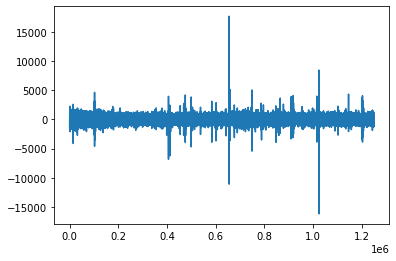

In [3]:
## get some stats

length = len(d1)/samplerate
print('TIME IN SECONDS: ', length)

## plot the first 5 seconds
plt.plot(d1[:int(5*samplerate)])

## SPECTROGRAM

In [4]:
import librosa
import librosa.display

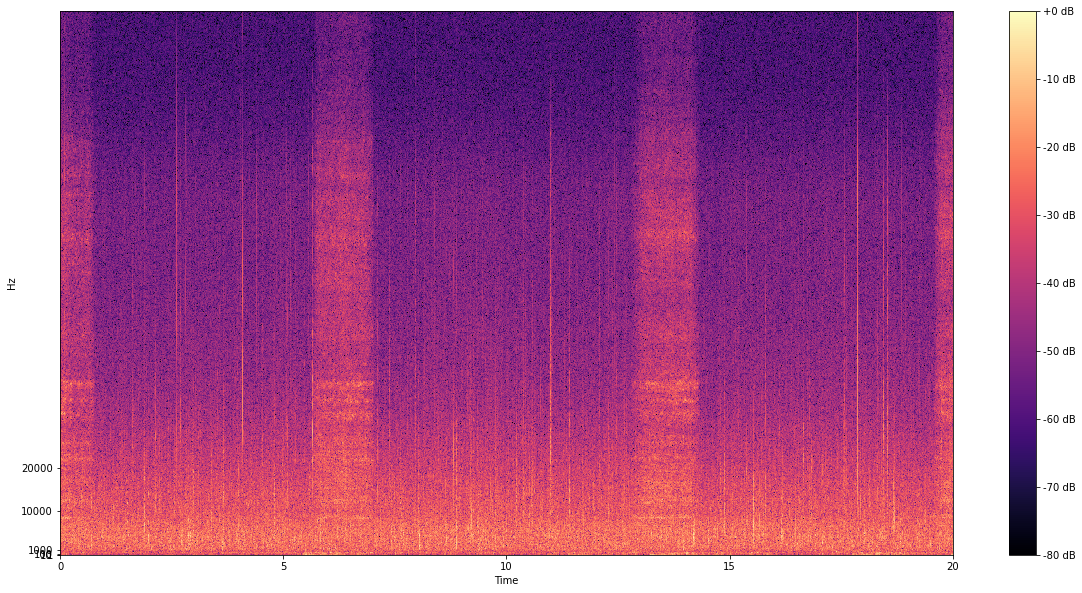

Text(0, 0.5, 'Frequency')

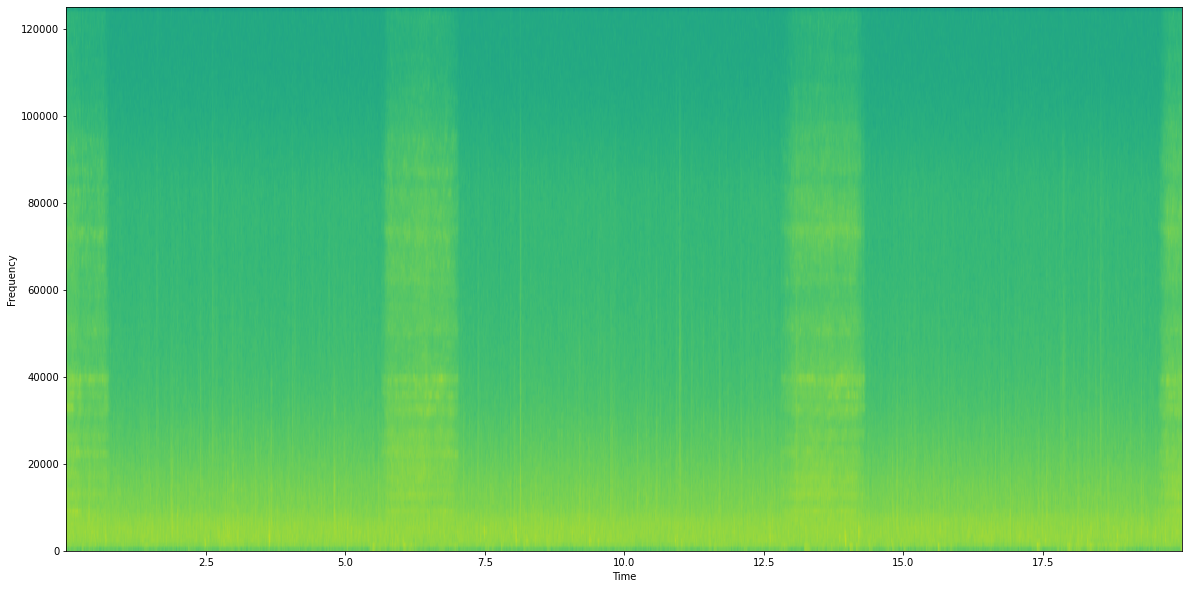

In [5]:
S = np.abs(librosa.stft(d1[:int(20*samplerate)].astype(np.float64)))

fig, ax = plt.subplots(figsize = (20,10))
img = librosa.display.specshow(librosa.amplitude_to_db(S,ref=np.max), y_axis='linear',sr=samplerate, x_axis='time', ax=ax)
ax.set_yticks([1,10,100,1000,10000, 20000])
fig.colorbar(img, ax=ax, format="%+2.0f dB")
plt.show()

fig, ax = plt.subplots(figsize = (20,10))
powerSpectrum, freqenciesFound, time, imageAxis = plt.specgram(d1[:int(20*samplerate)], Fs=samplerate)
plt.xlabel('Time')
plt.ylabel('Frequency')



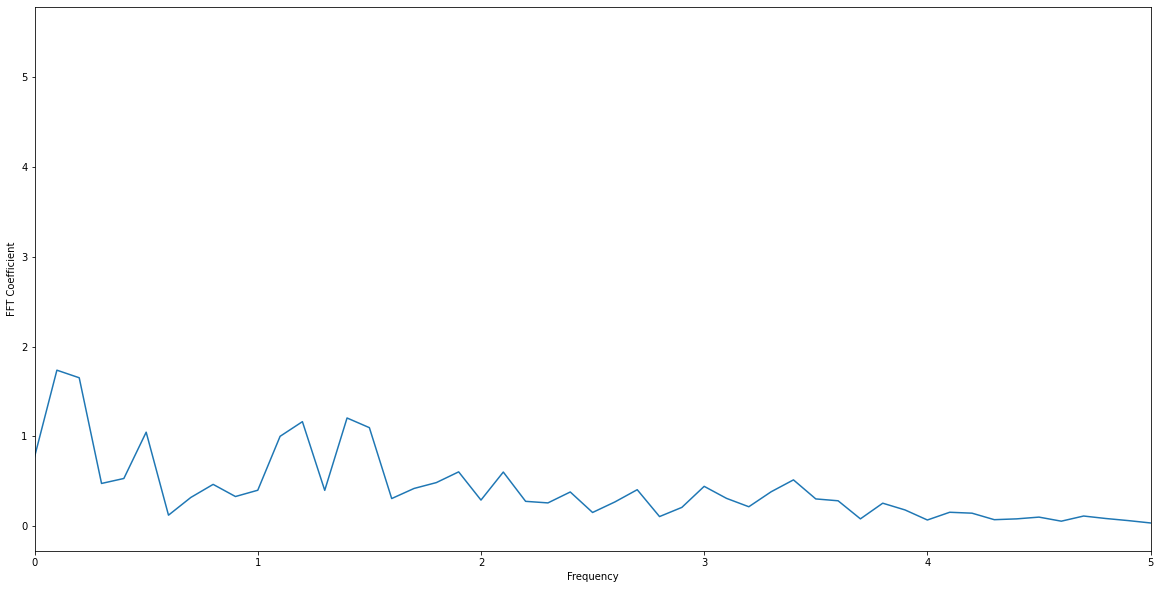

In [6]:
## FFT CHECK
import scipy
N = len(d1[:int(10*samplerate)])
T = 1/samplerate
yf = scipy.fftpack.fft(d1[:int(10*samplerate)])
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)

fig, ax = plt.subplots(figsize = (20,10))
ax.plot(xf, 2.0/N * np.abs(yf[:N//2]))
plt.xlim(0,5)
plt.xlabel('Frequency')
plt.ylabel('FFT Coefficient')
plt.show()

## TASK 2: PREPARE SOME DOA COMPUTATION

In [7]:
## mics N and P, check 1 second long frames
time = 1
overlap =1
segmented_N = (filtering.segment(d1[:int(samplerate*300)], 0, samplerate*(time), step = samplerate*(time)*overlap))
segmented_O = (filtering.segment(d2[:int(samplerate*300)], 0, samplerate*(time), step = samplerate*(time)*overlap ))
segmented_P = (filtering.segment(d3[:int(samplerate*300)], 0, samplerate*(time), step = samplerate*(time)*overlap ))

In [25]:
# store variables like some delays, powers
delays_NP = []
delays_OP = []
delays_NO = []

good_frame_delays_NO = []
good_frame_delays_NP = []
good_frame_delays_OP = []

powers_N = []
powers_O =[]
powers_P =[]
for i, (b1, b2,b3) in enumerate(zip(segmented_N, segmented_O, segmented_P)):

    ## go through frames, generate GCC-PHAT lags
    lag_NP, cc3 = filtering.gcc_methods(b1, b3,fs=samplerate, interp = 1, beamform = False)
    delays_NP.append(lag_NP)
    
    lag_OP, cc3 = filtering.gcc_methods(b2, b3,fs=samplerate, interp = 1, beamform = False)
    delays_OP.append(lag_OP)
    
    lag_NO, cc3 = filtering.gcc_methods(b1, b2,fs=samplerate, interp = 1, beamform = False)
    delays_NO.append(lag_NO)
    
    thresh = 1e11
    
    # get energy in certain bands to select good frames, for each pair of hydrophones
    b4 = (b1+b2)/2
    f,y = filtering.get_f_Y(b4)
    ratio = filtering.get_breathing_band(f, np.abs(y), samplerate)
    ratio = np.sum(np.abs(b4**2))
    powers_N.append(ratio)
    if(ratio > thresh):
        good_frame_delays_NO.append(lag_NO)
    else:
        good_frame_delays_NO.append(np.nan)
    
    b4 = (b2+b3)/2
    f,y = filtering.get_f_Y(b4)
    ratio = filtering.get_breathing_band(f, np.abs(y), samplerate)
    ratio = np.sum(np.abs(b4**2))
    powers_O.append(ratio)
    if(ratio > thresh):
        good_frame_delays_OP.append(lag_OP)
    else:
        good_frame_delays_OP.append(np.nan)
    
    b4 = (b1+b3)/2
    f,y = filtering.get_f_Y(b4)
    ratio = filtering.get_breathing_band(f, np.abs(y), samplerate)
    ratio = np.sum(np.abs(b4**2))
    powers_P.append(ratio)
    if(ratio > thresh):
        good_frame_delays_NP.append(lag_NP)
    else:
        good_frame_delays_NP.append(np.nan)

order = 1
delays_NP= ndimage.median_filter(np.array(delays_NP), order)
delays_OP= ndimage.median_filter(np.array(delays_OP), order)
delays_NO= ndimage.median_filter(np.array(delays_NO), order)


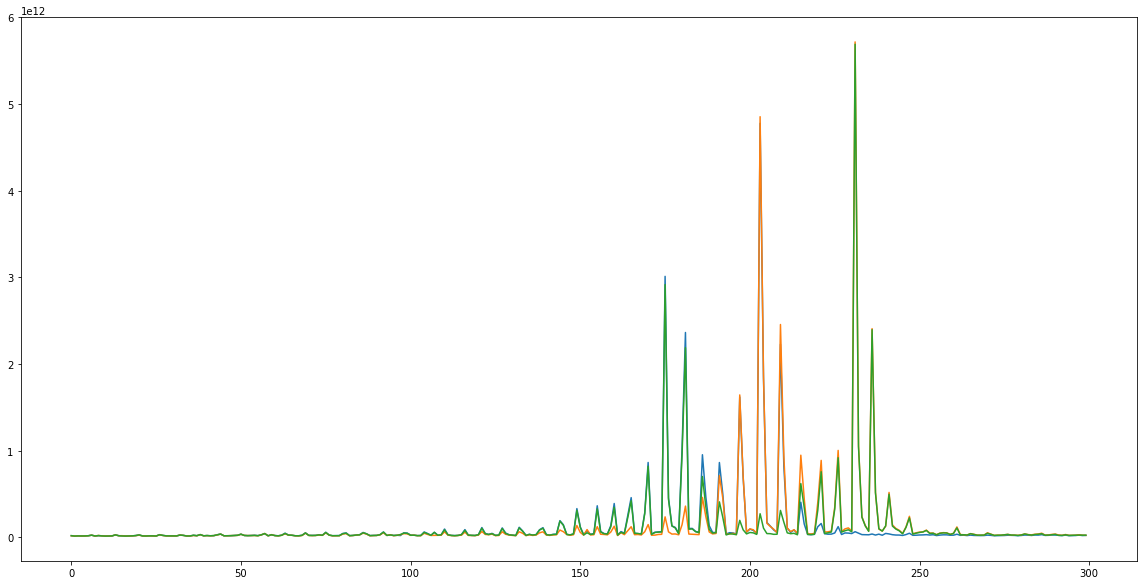

In [26]:
plt.figure(figsize=(20,10))
plt.plot(powers_N)
plt.plot(powers_O)
plt.plot(powers_P)


<ipython-input-27-29d28b40908a>:18: RuntimeWarning: invalid value encountered in arcsin
  theta = np.arcsin(x*v/(samplerate*d/2) )
<ipython-input-27-29d28b40908a>:25: RuntimeWarning: invalid value encountered in arcsin
  theta = np.arcsin(x*v/(samplerate*(d)) )
<ipython-input-27-29d28b40908a>:32: RuntimeWarning: invalid value encountered in arcsin
  theta = np.arcsin(x*v/(samplerate*(d)) )
<ipython-input-27-29d28b40908a>:41: RuntimeWarning: invalid value encountered in arcsin
  theta = np.arcsin(x*v/(samplerate*(d*2)))
<ipython-input-27-29d28b40908a>:48: RuntimeWarning: invalid value encountered in arcsin
  theta = np.arcsin(x*v/(samplerate*(d)) )
<ipython-input-27-29d28b40908a>:55: RuntimeWarning: invalid value encountered in arcsin
  theta = np.arcsin(x*v/(samplerate*(d)) )


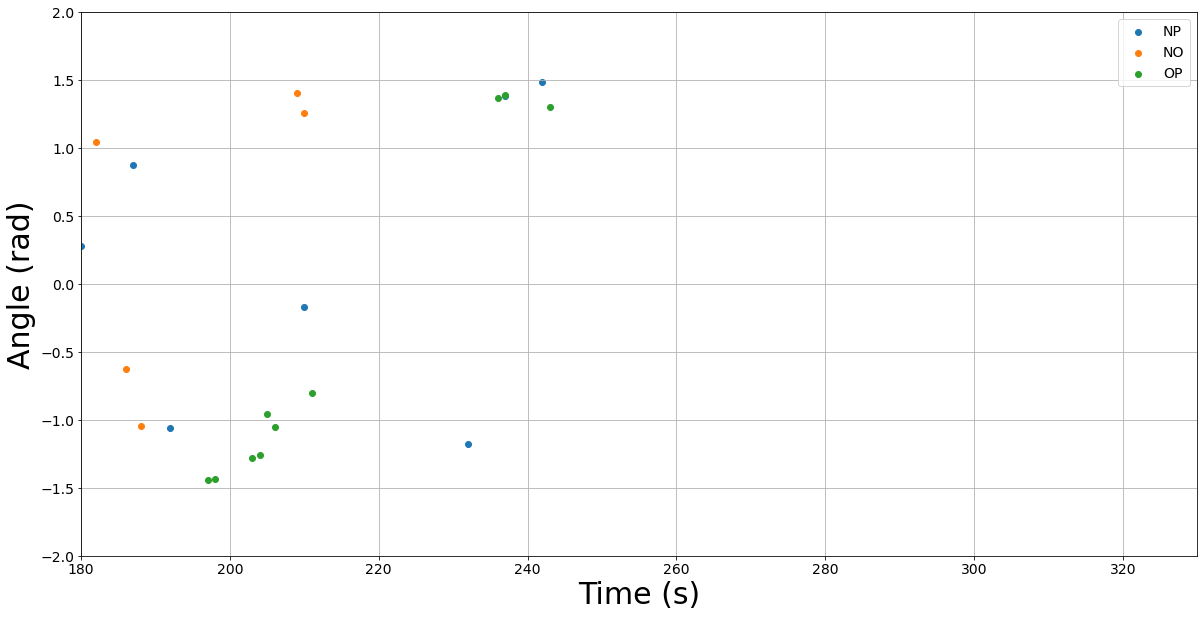

In [27]:
import pandas as pd
v = 1520
d = 28
angles_NO = []
angles_NP = []
angles_OP = []
good_frame_angles_NP=[]
good_frame_angles_NO=[]

good_frame_angles_OP=[]

# theta = np.arcsin(tau*v)/d

for i, x in enumerate(delays_NP):
    if(np.isnan(x)):
        angles_NP.append(np.nan)
    else:
        theta = np.arcsin(x*v/(samplerate*d/2) )  
        angles_NP.append(theta)

for i, x in enumerate(delays_NO):
    if(np.isnan(x)):
        angles_NO.append(np.nan)
    else:
        theta = np.arcsin(x*v/(samplerate*(d)) )  
        angles_NO.append(theta)
        
for i, x in enumerate(delays_OP):
    if(np.isnan(x)):
        angles_OP.append(np.nan)
    else:
        theta = np.arcsin(x*v/(samplerate*(d)) )  
        angles_OP.append(theta)
        
        
        
for i, x in enumerate(good_frame_delays_NP):
    if(np.isnan(x)):
        good_frame_angles_NP.append(np.nan)
    else:
        theta = np.arcsin(x*v/(samplerate*(d*2)))  
        good_frame_angles_NP.append(theta)
        
for i, x in enumerate(good_frame_delays_NO):
    if(np.isnan(x)):
        good_frame_angles_NO.append(np.nan)
    else:
        theta = np.arcsin(x*v/(samplerate*(d)) )  
        good_frame_angles_NO.append(theta)
        
for i, x in enumerate(good_frame_delays_OP):
    if(np.isnan(x)):
        good_frame_angles_OP.append(np.nan)
    else:
        theta = np.arcsin(x*v/(samplerate*(d)) )  
        good_frame_angles_OP.append(theta)
        
xs = np.arange(0,len(good_frame_angles_NP))

plt.figure(figsize = (20,10))


# plt.scatter(time*xs*overlap, pd.Series(np.array(angles_OP)), label = 'OP')
# plt.scatter(time*xs*overlap, pd.Series(np.array(angles_NO)), label = 'NO')
# plt.scatter(time*xs*overlap, pd.Series(np.array(angles_NP)), label = 'NP')

plt.scatter(time*xs*overlap, pd.Series(np.array(good_frame_angles_NP)), label = 'NP')
plt.scatter(time*xs*overlap, pd.Series(np.array(good_frame_angles_NO)), label = 'NO')
plt.scatter(time*xs*overlap, pd.Series(np.array(good_frame_angles_OP)), label = 'OP')



plt.ylim(-2,2)
plt.xlim(180,330)

plt.grid()
plt.legend(fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlabel('Time (s)', size = 30)
plt.ylabel('Angle (rad)', size = 30)
plt.show()

In [17]:
idx1 = np.where(~np.isnan(good_frame_angles_NO))
idx2 = np.where(~np.isnan(good_frame_angles_OP))
idx3 = np.where(~np.isnan(good_frame_angles_NP))

idx1, idx2,idx3

((array([  2,   8,  10,  11,  15,  17,  22,  24,  25,  27,  29,  35,  36,
          40,  42,  48,  54,  58,  59,  60,  62,  65,  71,  82,  84,  89,
          90,  94,  97, 101, 102, 106, 107, 109, 114, 117, 119, 123, 125,
         129, 130, 137, 140, 141, 142, 143, 144, 145, 146, 148, 149, 150,
         151, 153, 154, 158, 159, 161, 162, 163, 166, 167, 168, 169, 170,
         171, 172, 173, 174, 176, 182, 186, 188, 190, 194, 196, 199, 200,
         202, 208, 209, 210, 214, 217, 218, 219, 222, 224, 225, 227, 230,
         232, 235, 236, 239, 240, 243, 244, 248, 250, 252, 254, 257, 258,
         259, 262, 263, 264, 267, 269, 273, 274, 275, 282, 284, 289, 290,
         291, 292, 293, 294, 295, 297, 298]),),
 (array([  2,   8,   9,  10,  11,  12,  15,  18,  22,  25,  27,  28,  30,
          31,  34,  35,  36,  42,  45,  46,  48,  58,  59,  61,  65,  66,
          71,  72,  73,  74,  77,  83,  89,  90,  94,  95, 100, 102, 103,
         106, 108, 109, 114, 117, 118, 124, 129, 130, 131, 134, 

-1.043614993999629 -1.1510547527707817


(-3.0, 14.0)

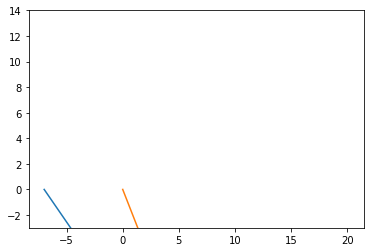

In [18]:
a1 = good_frame_angles_NO[188]
a2= good_frame_angles_NP[188]
print(a1,a2)

x = np.linspace(-50,50)
y1 = 40*np.sin(a1)
x1 = 40*np.cos(a1)

y2 = 40*np.sin(a2)
x2 = 40*np.cos(a2)


plt.plot([-7,x1],[0,y1])
plt.plot([0,x2],[0,y2])
plt.ylim(-3,14)

In [131]:
y1, y2

(-34.52571428571429, 16.45580149295409)

1.2940256129170231 -0.7957662664119918


(0.0, 7.0)

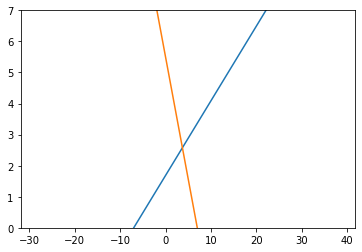

In [149]:
a1 = good_frame_angles_NO[211]
a2= good_frame_angles_OP[211]
print(a1,a2)

x = np.linspace(-50,50)
x1 = 40*np.sin(a1)
y1 = 40*np.cos(a1)

x2 = 40*np.sin(a2)
y2 = 40*np.cos(a2)


plt.plot([-7,x1],[0,y1])
plt.plot([7,x2],[0,y2])
plt.ylim(0,7)

0.9590190353853748 -0.015200585362194312


(0.0, 7.0)

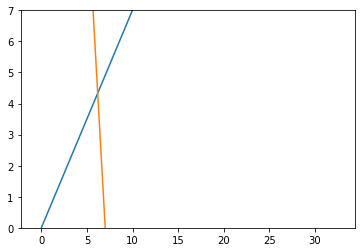

In [150]:
a1 = good_frame_angles_NP[223]
a2= good_frame_angles_OP[222]
print(a1,a2)

x = np.linspace(-50,50)
x1 = 40*np.sin(a1)
y1 = 40*np.cos(a1)

x2 = 40*np.sin(a2)
y2 = 40*np.cos(a2)


plt.plot([0,x1],[0,y1])
plt.plot([7,x2],[0,y2])
plt.ylim(0,7)

1.4157216538305581 -0.7267671841944944


(0.0, 7.0)

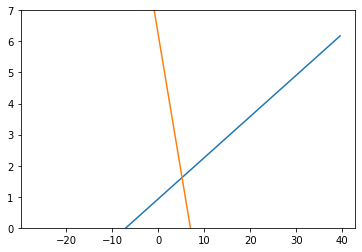

In [156]:
a1 = good_frame_angles_NO[231]
a2= good_frame_angles_OP[230]
print(a1,a2)

x = np.linspace(-50,50)
x1 = 40*np.sin(a1)
y1 = 40*np.cos(a1)

x2 = 40*np.sin(a2)
y2 = 40*np.cos(a2)


plt.plot([-7,x1],[0,y1])
plt.plot([7,x2],[0,y2])
plt.ylim(0,7)

In [157]:
print(abs(good_frame_angles_OP[230]-good_frame_angles_OP[222])/8)
print(abs(good_frame_angles_OP[222]-good_frame_angles_OP[211])/11)

0.08894582485403751
0.0709605164590725


In [118]:
delta_d = (8*np.tan(good_frame_angles_OP[222]) - 8*(good_frame_angles_OP[211]))
delta_d/11

0.5676832801481237

In [123]:
delta_d = (8*np.tan(good_frame_angles_NP[204]) - 8*(good_frame_angles_NP[188]))
delta_d/(204-188)

0.31451628077471844